
# Red-sequence Modeling
---------------------------------------

Steps:
* Model dependence with stellar mass, fit red-sequence (z-band abs mag)
* Only Red galaxies, wider redshift bin
* One model for each color
* I want only the red-sequence color offset, i.e. residuals

In [17]:
import numpy as np
import os
import esutil

import matplotlib.pyplot as plt
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import astropy.io.ascii as at

## Load DES Deep Field

In [86]:
# path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
path = '/Users/jesteves/Downloads/'
fname = path+'desCosmosML_sample.fits'
joined = Table(getdata(fname))

In [2]:
def transform_to_1d(x,y):
    ynew = y[:,1]
    xnew = np.vstack([x.T,y[:,0]]).T
    return xnew, ynew[:,np.newaxis]

In [27]:
path = '../data/'
x_train = np.load(path+'qf_x_train.npy')
y_train = np.load(path+'qf_y_train.npy')

x_test = np.load(path+'qf_x_test.npy')
y_test = np.load(path+'qf_y_test.npy')

In [48]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)
xall = np.vstack([x_test1d, x_train1d])
yall = np.vstack([y_test, y_train])

In [141]:
magsErr_train = np.c_[[np.array(joined['MAGERR_%s'%bp.upper()][joined['Train']]) for bp in ['g','r','i','z']]].T
magsErr_test = np.c_[[np.array(joined['MAGERR_%s'%bp.upper()][~joined['Train']]) for bp in ['g','r','i','z']]].T
magsErr_all = np.vstack([magsErr_test, magsErr_train])

In [286]:
colors_all = np.c_[[xall[:,4+ix]-xall[:,4+ix+1] for ix in range(3)]].T

# Set Fit Variables

In [349]:
# red and bright
qf = ((yall[:,2]).astype(bool))&(yall[:,1]<=-15.)&(np.abs(colors_all[:,0])<=4)

z = xall[qf,-2]
mags = xall[qf,:4]
mags_err = magsErr_all[qf,:]
colors = np.c_[[mags[:,ix]-mags[:,ix+1] for ix in range(3)]].T
abs_mag_i = yall[qf,1]+20.

### Make Bins

In [310]:
def make_bins(x,xbins):
    indices = []
    xmd     = 0.5*(xbins[1:]+xbins[:-1])
    for xl,xh in zip(xbins[:-1],xbins[1:]):
        w, = np.where((x<=xh)&(x>xl))
        indices.append(w)
    return indices,xmd

In [599]:
zbins = np.percentile(z, np.linspace(0,100,31))
zbins[-1] = 1.5
# zbins = np.append(zbins, np.percentile(z[z>zbins[-1]], np.linspace(0,100,3))[1:])

zkeys, zmed = make_bins(z, zbins)
zbins

array([0.02      , 0.1618    , 0.21619999, 0.26949999, 0.31850001,
       0.34      , 0.35789999, 0.37709999, 0.40149999, 0.43979999,
       0.47459999, 0.5126    , 0.5517    , 0.60350001, 0.63980001,
       0.67000002, 0.68480003, 0.70389998, 0.72640002, 0.76340002,
       0.81199998, 0.83420002, 0.85189998, 0.87180001, 0.90424001,
       0.93440002, 0.96719998, 0.9989    , 1.09889996, 1.19659996,
       1.5       ])

Text(0.5, 0, 'Redshift')

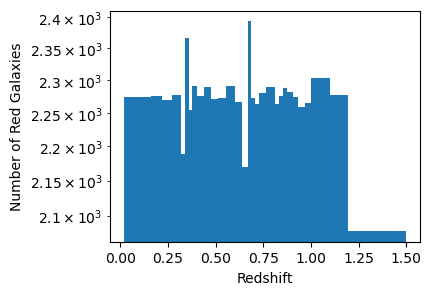

In [600]:
plt.figure(figsize=(4,3))
_ = plt.hist(z,bins=zbins)
plt.yscale('log')
# plt.ylim(90.,)
plt.ylabel('Number of Red Galaxies')
plt.xlabel('Redshift')

## Fit Red-Sequence

In [601]:
color_labels = [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]

In [602]:
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import warnings

def rsFit(x1,y,err):
    g_init = models.Linear1D(1)
    fit = fitting.LevMarLSQFitter()
    or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.)

    # Ignore model linearity warning from the fitter
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # Fit
        filtered_data, model = or_fit(g_init, x1, y,weights=1.0/err)
        # filtered_data, model = or_fit(g_init, x1, y)
        mask = np.logical_not(np.ma.getmaskarray(filtered_data))
    return filtered_data.parameters, model

In [603]:
zb = 19

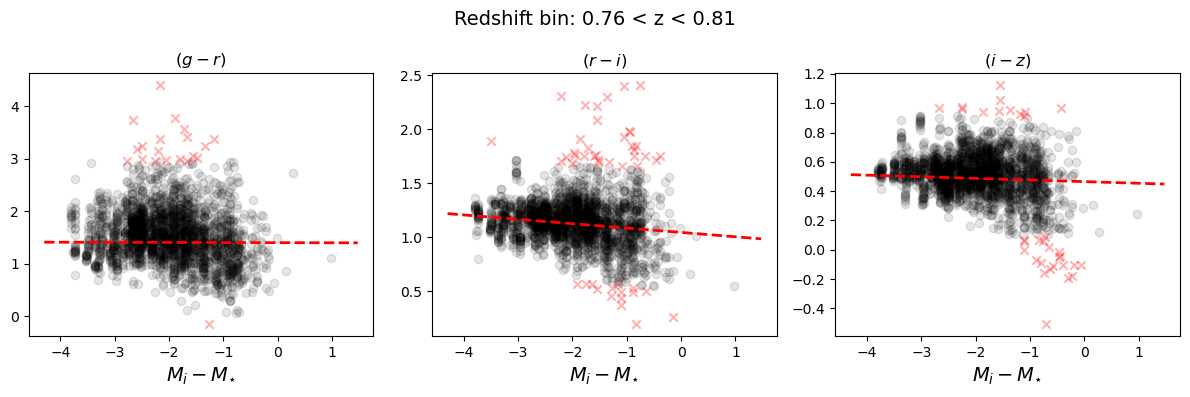

In [604]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

for ix in range(3):
    zcut = (z>=zbins[zb])&(z<=zbins[zb+1])
    coefs, mask = rsFit(abs_mag_i[zcut],colors[zcut,ix],mags_err[zcut,ix])
    
    mibins = np.linspace(np.min(abs_mag_i[zcut])-0.5,np.max(abs_mag_i[zcut])+0.5,21)
    
    axs[ix].plot(mibins, np.poly1d(coefs)(mibins),'r--',lw=2)
    axs[ix].scatter(abs_mag_i[zcut][~mask], colors[zcut,ix][~mask],alpha=0.1,color='k')
    axs[ix].scatter(abs_mag_i[zcut][mask], colors[zcut,ix][mask],alpha=0.3,color='r',marker='x')
    axs[ix].set_title(color_labels[ix],fontsize=12)
    _ = axs[ix].set_xlabel('$M_i-M_{\star}$',fontsize=14)
fig.suptitle('Redshift bin: %.2f < z < %.2f'%(zbins[zb],zbins[zb+1]),fontsize=14)
fig.tight_layout()

In [605]:
nbins = len(zkeys)
ncolors = 3
parameters = np.zeros((nbins,ncolors,2))

for i,idx in enumerate(zkeys):
    for j in range(ncolors):
        coefs, mask = rsFit(abs_mag_i[idx],colors[idx,j],mags_err[idx,j])
        parameters[i,j,:] = coefs

In [606]:
## finer binning scheme
zbins2 = np.percentile(z, np.linspace(0,100,71))
zbins2[-1] = 1.5
# zbins = np.append(zbins, np.percentile(z[z>zbins[-1]], np.linspace(0,100,3))[1:])

zkeys2, zmed2 = make_bins(z, zbins2)
zbins2

nbins2 = len(zkeys2)
parameters2 = np.zeros((nbins2,ncolors,2))

for i,idx in enumerate(zkeys2):
    for j in range(ncolors):
        coefs, mask = rsFit(abs_mag_i[idx],colors[idx,j],mags_err[idx,j])
        parameters2[i,j,:] = coefs

In [607]:
final_zmed = np.hstack([zmed,zmed2])
final_parameters = np.vstack([parameters,parameters2])

ixsort = np.argsort(final_zmed)
final_zmed = final_zmed[ixsort]
final_parameters = final_parameters[ixsort]
final_parameters.shape

(100, 3, 2)

In [608]:
from scipy import interpolate
def doInter(xnew, x, y):
    tck = interpolate.splrep(x, y)
    return interpolate.splev(xnew, tck)

In [609]:
from scipy.signal import savgol_filter
final_model = np.zeros_like(final_parameters)

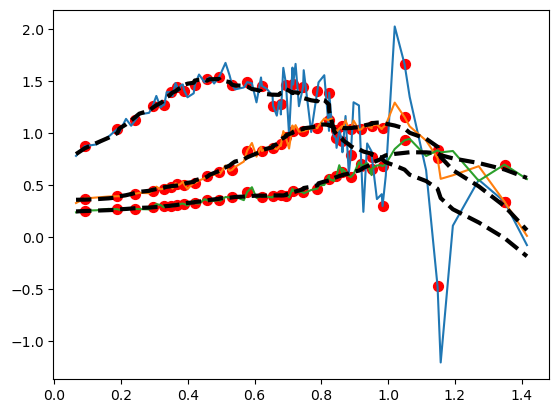

In [612]:
plt.plot(final_zmed,final_parameters[:,:,1])
for i in range(3):
    final_model[:,i,1] = savgol_filter(final_parameters[:,i,1],50,5)
    final_model[:,i,0] = savgol_filter(final_parameters[:,i,0],50,5)
    
    plt.scatter(zmed,parameters[:,i,1],color='r',s=50)
    plt.plot(final_zmed,final_model[:,i,1] ,'k--',lw=3)

In [619]:
print('Saved File: ../data/rs_slope_desDeepField')
np.savez('../data/rs_slope_desDeepField', z=final_zmed, coefs=final_model)

Saved File: ../data/rs_slope_desDeepField


In [620]:
npzfile = np.load('../data/rs_slope_desDeepField.npz')
npzfile['z'] # zmed

array([0.06485   , 0.0909    , 0.12687571, 0.16202572, 0.189     ,
       0.19465   , 0.21465   , 0.22993143, 0.24284999, 0.25468142,
       0.28379999, 0.294     , 0.3054    , 0.31815   , 0.32799999,
       0.32925001, 0.33645   , 0.3451    , 0.34895   , 0.3538    ,
       0.3628    , 0.36749999, 0.37145001, 0.37755001, 0.38465001,
       0.38929999, 0.3987    , 0.4174    , 0.42064999, 0.4333    ,
       0.44994999, 0.45719999, 0.46525   , 0.4786    , 0.4936    ,
       0.4963    , 0.5126    , 0.5248    , 0.53215   , 0.54095   ,
       0.56755   , 0.5776    , 0.59175   , 0.60542429, 0.6189743 ,
       0.62165001, 0.63595   , 0.65358714, 0.65490001, 0.66623715,
       0.67285001, 0.67740002, 0.67835   , 0.68575001, 0.69435   ,
       0.69435   , 0.70299998, 0.71318855, 0.71515   , 0.72248857,
       0.73255   , 0.74490002, 0.74684998, 0.7692    , 0.7877    ,
       0.79124999, 0.80849999, 0.82265002, 0.8231    , 0.83080003,
       0.83755001, 0.84305   , 0.84529999, 0.85334998, 0.86184

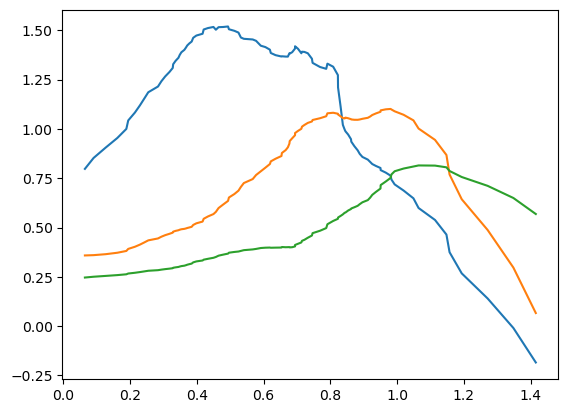

In [622]:
plt.plot(npzfile['z'],npzfile['coefs'][:,:,1]) # mean color at Mi=-20.